In [ ]:
from umap import UMAP
import pandas as pd
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from rdkit.Chem import AllChem
from rdkit import DataStructs
from rdkit import Chem
from matplotlib import pyplot as plt
from sklearn.metrics import silhouette_score
from matplotlib.colors import TABLEAU_COLORS

TEST_SET_TANIMOTO_CUTOFF = 0.5

# Load Data

In [ ]:
df = pd.read_csv(r'processed_datasets\10uM_resistant_pneumococcus_augmented_dataset_v7.csv')
mfps = [AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(smiles), 3, 2048) for smiles in df['Smiles'].values]

# Withheld Test Set

In [ ]:
molecule_maxSim = []
for idx, target_fp in enumerate(mfps):
    mfpDBs = [x for i, x in enumerate(mfps) if i != idx]
    simMatrix = DataStructs.BulkTanimotoSimilarity(mfps[idx], mfpDBs)
    maxSim = np.max(simMatrix)
    molecule_maxSim.append(maxSim)

outlier = df[np.array(molecule_maxSim) < TEST_SET_TANIMOTO_CUTOFF]
cv = df[np.array(molecule_maxSim) >= TEST_SET_TANIMOTO_CUTOFF]

# print withheld test set summary
print(outlier['final_activity_label'].value_counts())
print(outlier['final_activity_label'].value_counts() / outlier.shape[0])

# UMAP Split

In [ ]:
cvFPs = np.array(mfps)[cv.index.values]
umap_red = UMAP(n_neighbors=100, n_components=2, metric='jaccard', random_state=34)
morgan_fps_umap2 = umap_red.fit_transform(cvFPs)

c:\Users\mdhya\anaconda3\envs\digichem2\lib\site-packages\umap\umap_.py:1880: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(
c:\Users\mdhya\anaconda3\envs\digichem2\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


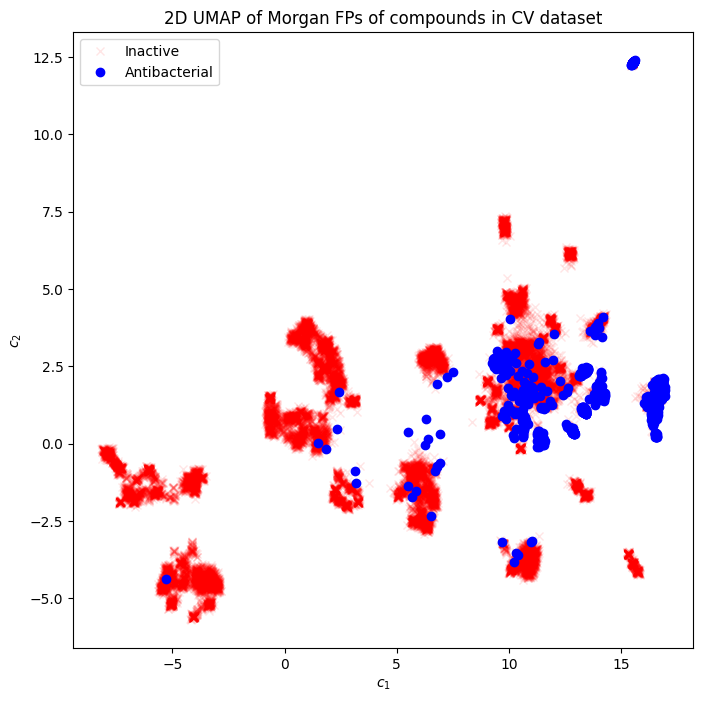

In [ ]:
## visualizing the chemical space of ligands targeting viral protein in BindingDB dataset
plt.figure(figsize = (8, 8))

# plt.subplot(122)
plt.plot(morgan_fps_umap2[:, 0][cv.final_activity_label==0], morgan_fps_umap2[:, 1][cv.final_activity_label==0], 'rx', label = 'Inactive', alpha=0.1)
plt.plot(morgan_fps_umap2[:, 0][cv.final_activity_label==1], morgan_fps_umap2[:, 1][cv.final_activity_label==1], 'bo', label = 'Antibacterial')

plt.legend(loc = 'best', shadow = False, scatterpoints = 1)
plt.title('2D UMAP of Morgan FPs of compounds in CV dataset')
plt.xlabel('$c_1$')
plt.ylabel('$c_2$')

plt.subplots_adjust(wspace = 0.3)
# plt.savefig('UMAP_before_clustering.png')
plt.show()

## n_cluster determination - Silhouette score

k_at_max_score:  26


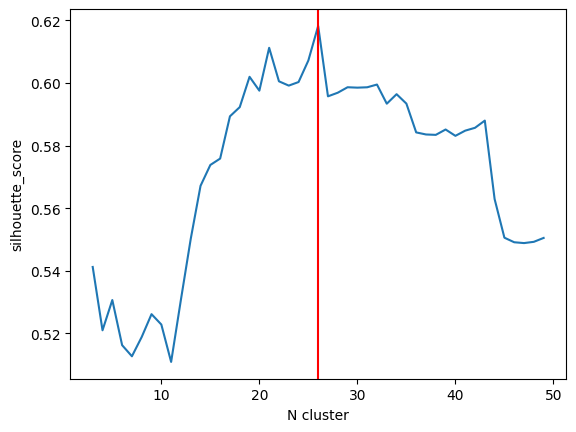

In [ ]:
silhouette_scores = []
k_start = 3
k_end = 50
for k in range(k_start,k_end):
    cluster_algo = AgglomerativeClustering(n_clusters=k)
    clustered_morgan_fps_umap2 = cluster_algo.fit_predict(morgan_fps_umap2)
    silhouette_scores.append(silhouette_score(morgan_fps_umap2, clustered_morgan_fps_umap2))

k_at_max_score = np.argmax(silhouette_scores)+k_start
print("k_at_max_score: ", k_at_max_score)
plt.plot(range(k_start,k_end), silhouette_scores)
plt.axvline(x=k_at_max_score, color='r')
plt.xlabel('N cluster')
plt.ylabel('silhouette_score')
plt.show()


In [ ]:
cluster_algo = AgglomerativeClustering(n_clusters=k_at_max_score, compute_distances=True)
clustered_morgan_fps_umap2 = cluster_algo.fit_predict(morgan_fps_umap2)
cv['cluster_id'] = clustered_morgan_fps_umap2
# cv.to_json(f'clustered{k}_CV_10uM_resistant_pneumococcus_augmented_dataset.json')
cv.groupby('cluster_id')['final_activity_label'].agg(['mean','count','sum'])

C:\Users\mdhya\AppData\Local\Temp\ipykernel_29892\2140978686.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cv['cluster_id'] = clustered_morgan_fps_umap2


,mean,count,sum
cluster_id,,,
0,0.004025,3230,13
1,0.000402,2490,1
2,0.106929,1833,196
3,0.022914,2924,67
4,0.001505,1993,3
5,0.002996,2003,6
6,0.372703,1524,568
7,0.002024,1482,3
8,0.000000,627,0


## Visualization

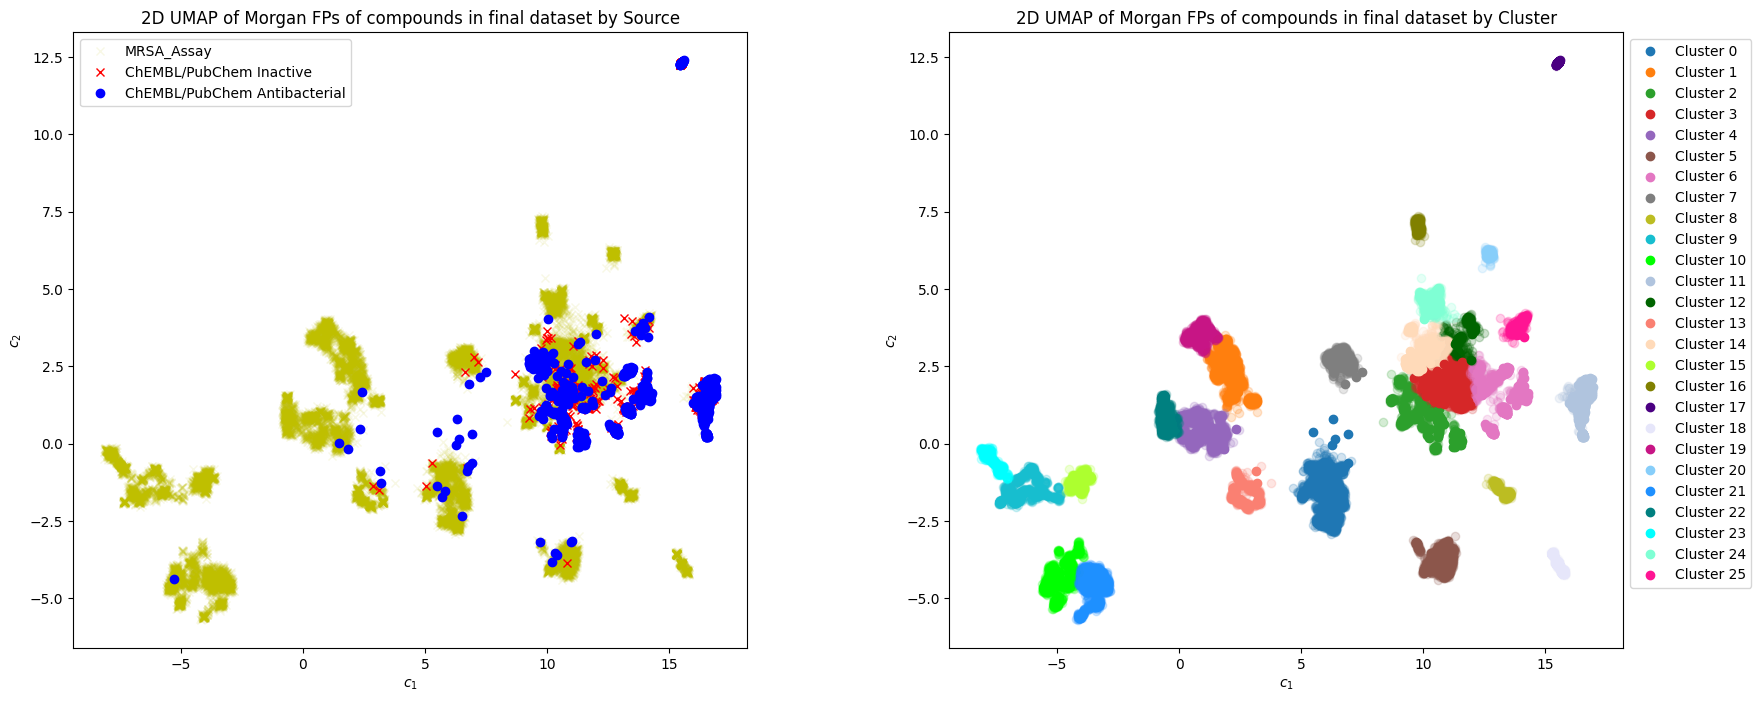

In [ ]:
## visualizing the chemical space of ligands targeting viral protein in BindingDB dataset
pos = cv.final_activity_label==1

plt.figure(figsize = (20, 8))
extra_colors = ['lime', 'lightsteelblue', 'darkgreen', 'salmon', 'peachpuff', 
                'greenyellow', 'olive', 'indigo', 'lavender', 'mediumvioletred',
                'lightskyblue', 'dodgerblue', 'teal', 'aqua', 'aquamarine', 'deeppink']
colors = [x for x in TABLEAU_COLORS.keys()] + extra_colors

# plt.subplot(221)
# plt.plot(morgan_fps_umap2[:, 0][cv.final_activity_label==0], morgan_fps_umap2[:, 1][cv.final_activity_label==0], 'rx', label = 'Inactive', alpha=0.1)
# plt.plot(morgan_fps_umap2[:, 0][cv.final_activity_label==1], morgan_fps_umap2[:, 1][cv.final_activity_label==1], 'bo', label = 'Antibacterial')

# plt.legend(loc = 'best', shadow = False, scatterpoints = 1)
# plt.title('2D UMAP of Morgan FPs of compounds in final dataset by labels')
# plt.xlabel('$c_1$')
# plt.ylabel('$c_2$')

plt.subplot(121)
plt.plot(morgan_fps_umap2[:, 0][cv.source=='MRSA_Wong2024'], morgan_fps_umap2[:, 1][cv.source=='MRSA_Wong2024'], 'yx', label = 'MRSA_Assay', alpha=0.1)
plt.plot(morgan_fps_umap2[:, 0][cv.source.isin(['ChEMBL','PubChem']) & ~pos], 
         morgan_fps_umap2[:, 1][cv.source.isin(['ChEMBL','PubChem']) & ~pos], 'rx', label = 'ChEMBL/PubChem Inactive')
plt.plot(morgan_fps_umap2[:, 0][cv.source.isin(['ChEMBL','PubChem']) & pos], 
         morgan_fps_umap2[:, 1][cv.source.isin(['ChEMBL','PubChem']) & pos], 'bo', label = 'ChEMBL/PubChem Antibacterial')
plt.legend(loc = 'best', shadow = False, scatterpoints = 1)
plt.title('2D UMAP of Morgan FPs of compounds in final dataset by Source')
plt.xlabel('$c_1$')
plt.ylabel('$c_2$')

ax222 = plt.subplot(122)

for i, color in enumerate(colors[:k_at_max_score]):
    cluster_cond = cv['cluster_id']==i
    plt.plot(morgan_fps_umap2[:, 0][cluster_cond&(~pos)], 
             morgan_fps_umap2[:, 1][cluster_cond&(~pos)], 
             'o', color=color, alpha=0.2)
    
for i, color in enumerate(colors[:k_at_max_score]):
    cluster_cond = cv['cluster_id']==i
    plt.plot(morgan_fps_umap2[:, 0][cluster_cond&pos], 
             morgan_fps_umap2[:, 1][cluster_cond&pos], 
             'o', color=color, label = f'Cluster {i}')
# plt.plot(X_95[:, 0][y_wine == 1], X_95[:, 1][y_wine == 1], 'bs', label = 'Cultivar 2')
# plt.plot(X_95[:, 0][y_wine == 2], X_95[:, 1][y_wine == 2], 'g^', label = 'Cultivar 3')
ax222.legend( shadow=False, scatterpoints = 1, bbox_to_anchor=(1, 1))
plt.title('2D UMAP of Morgan FPs of compounds in final dataset by Cluster')
plt.xlabel('$c_1$')
plt.ylabel('$c_2$')

plt.subplots_adjust(wspace = 0.3)
# plt.savefig('UMAP_before_clustering.png')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 1600x1600 with 0 Axes>

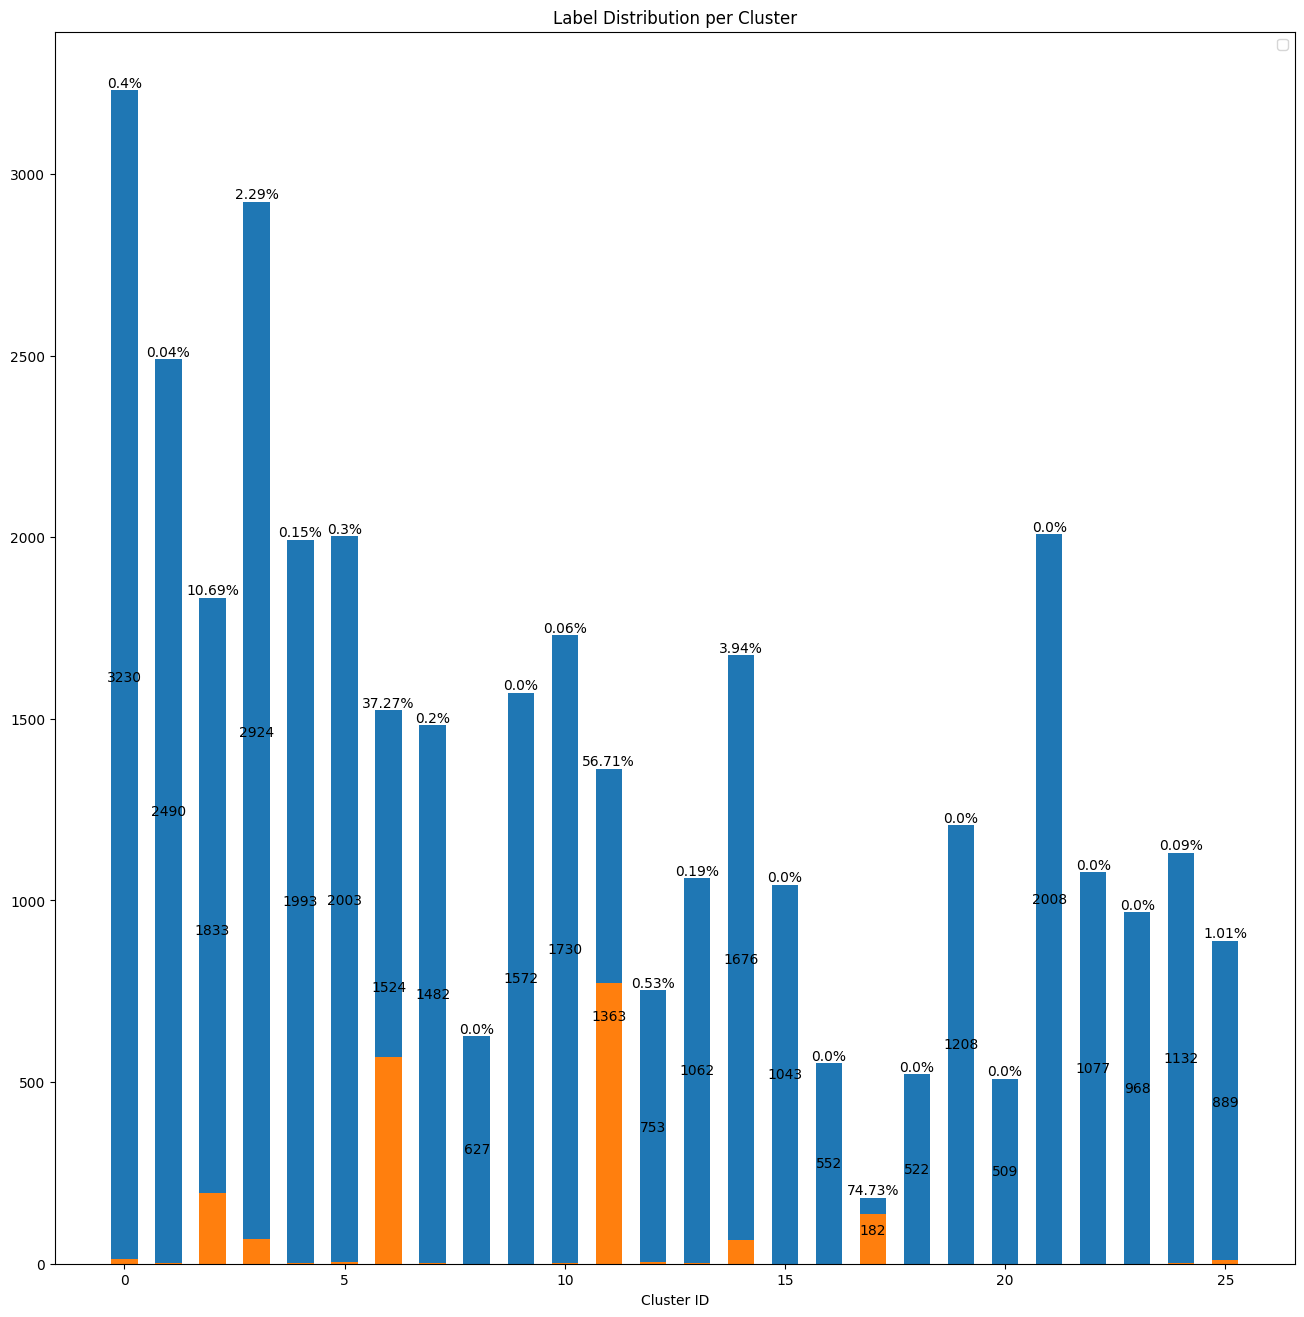

In [ ]:
summary = cv.groupby('cluster_id')['final_activity_label'].agg(['mean','count','sum'])

plt.figure(figsize = (16, 16))

width = 0.6  # the width of the bars: can also be len(x) sequence
fig, ax = plt.subplots(figsize=(16,16))
pct = ['{}%'.format(round(x*100, 2)) for x in summary['mean'].values]


p = ax.bar(summary.index, summary['count'], width)
ax.bar_label(p, labels=pct,label_type='edge')
ax.bar_label(p, labels=summary['count'],label_type='center')
p = ax.bar(summary.index, summary['sum'], width)
# ax.bar_label(p, label_type='center')
ax.set_xlabel('Cluster ID')

ax.set_title('Label Distribution per Cluster')
ax.legend()

plt.show()

# Updating original DF with clusterID

In [ ]:
df['cluster_id'] = -1
for cluster, group in cv.groupby('cluster_id'):
    df.loc[group.index.values, 'cluster_id'] = cluster
df.to_csv(r'processed_datasets\10uM_FP_clustered__resistant_pneumococcus_augmented_dataset_v7.csv')

# Appendix: Cluster Sample Check

In [ ]:
from PIL import Image
from io import BytesIO
from matplotlib import colors
from rdkit.Chem import Draw

def show_mol(d2d,mol,legend='',highlightAtoms=[]):
    # hcolor = colors.to_rgb('green')
    d2d.DrawMolecule(mol,legend=legend, highlightAtoms=highlightAtoms)
    d2d.FinishDrawing()
    bio = BytesIO(d2d.GetDrawingText())
    return Image.open(bio)

def show_images(imgs, nrows=3,buffer=5):
    height = 0
    width = 0
    for idx, img in enumerate(imgs):
        if idx < nrows:
            height += img.height
        if idx % nrows == 0:
            width += img.width
    height += buffer*(nrows-1)
    width += buffer*((len(imgs)//nrows)-1)
    print(width,height)
    res = Image.new("RGBA",(width,height))
    x = 0
    y = 0
    for idx, img in enumerate(imgs):
        # if idx == 20:
        if (idx % (nrows) == 0) and (idx != 0):
            x += img.width + buffer
            y = 0
        # print(x,y)
        res.paste(img,(x,y))
        y += img.height + buffer
        
    return res

In [ ]:
df = pd.read_csv(r'processed_datasets\10uM_FP_clustered__resistant_pneumococcus_augmented_dataset_v7.csv')
sampleDF = pd.DataFrame()
for idx, group in df.groupby(['cluster_id', 'final_activity_label']):
    n = 2 if idx[1]==0 else np.min([group.shape[0], 1])
    tmp = group.sample(n)
    sampleDF = pd.concat([sampleDF, tmp])

sampleDF = sampleDF.rename(columns={'Compound ID':'CID'})
sampleDF.head()

,CID,Smiles,Molecular_Weight,adjusted_value_uM,final_activity_label,Standard Type,Standard Relation,Standard Value,Standard Units,assay_id,assay_title,source,cluster_id
20794,BRD-K21615095,CC(=O)NO,75.032028,NaN,0,Growth Inhibition,None,0.994239,normalized %,None,None,MRSA_Wong2024,-1
10888,BRD-K31754360,Cc1cc(ccc1F)S(=O)(=O)NCC(=O)O,247.031457,NaN,0,Growth Inhibition,None,0.921615,normalized %,None,None,MRSA_Wong2024,-1
1758,CHEMBL4438477,CCCNc1ccc2c3c(cccc13)C(=O)N(CCCCCCCCCCCC1O[C@@...,875.940000,1.141631,1,MIC,'=',1.000000,ug.mL-1,CHEMBL4326518,Antibacterial activity against multidrug-resis...,ChEMBL,-1
6210,BRD-K46364548,C[C@H]1CN([C@@H](C)CO)C(=O)c2cccc(c2O[C@@H]1CN...,595.279469,NaN,0,Growth Inhibition,None,0.866978,normalized %,None,None,MRSA_Wong2024,0
26312,BRD-K47175110,C[C@@H]1CN([C@@H](C)CO)C(=O)c2cccc(c2O[C@H]1CN...,628.250870,NaN,0,Growth Inhibition,None,1.035783,normalized %,None,None,MRSA_Wong2024,0


1770 705


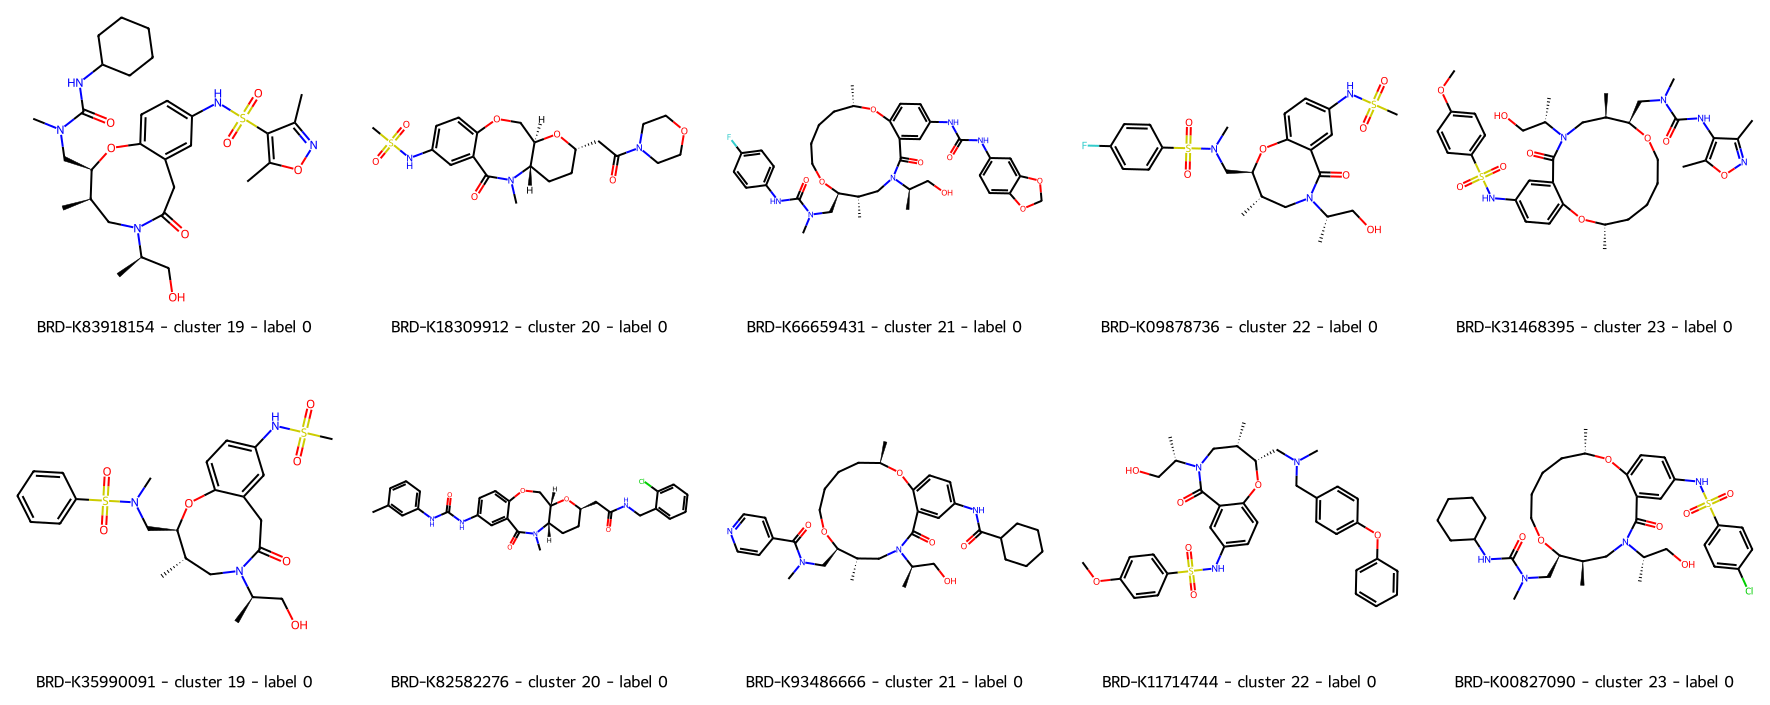

In [ ]:
imgs = []
for sm in sampleDF.itertuples():
    if sm.cluster_id not in summary[summary['sum']==0].index.values:
        continue

    # if sm.cluster_id <13 or sm.cluster_id==-1 or sm.cluster_id>=13:
    #     continue
    # print(sm)
    # break
    if sm.cluster_id >=19 and sm.cluster_id<30:
        d2d = Draw.MolDraw2DCairo(350,350)
        molecule = Chem.MolFromSmiles(sm.Smiles)
        imgs.append(show_mol(d2d,molecule,legend=f'{sm.CID} - cluster {sm.cluster_id} - label {sm.final_activity_label}'))

# imgs.append(show_mol(d2d,doravirine,legend='default palette'))
res = show_images(imgs, nrows=2)
res

1770 1415


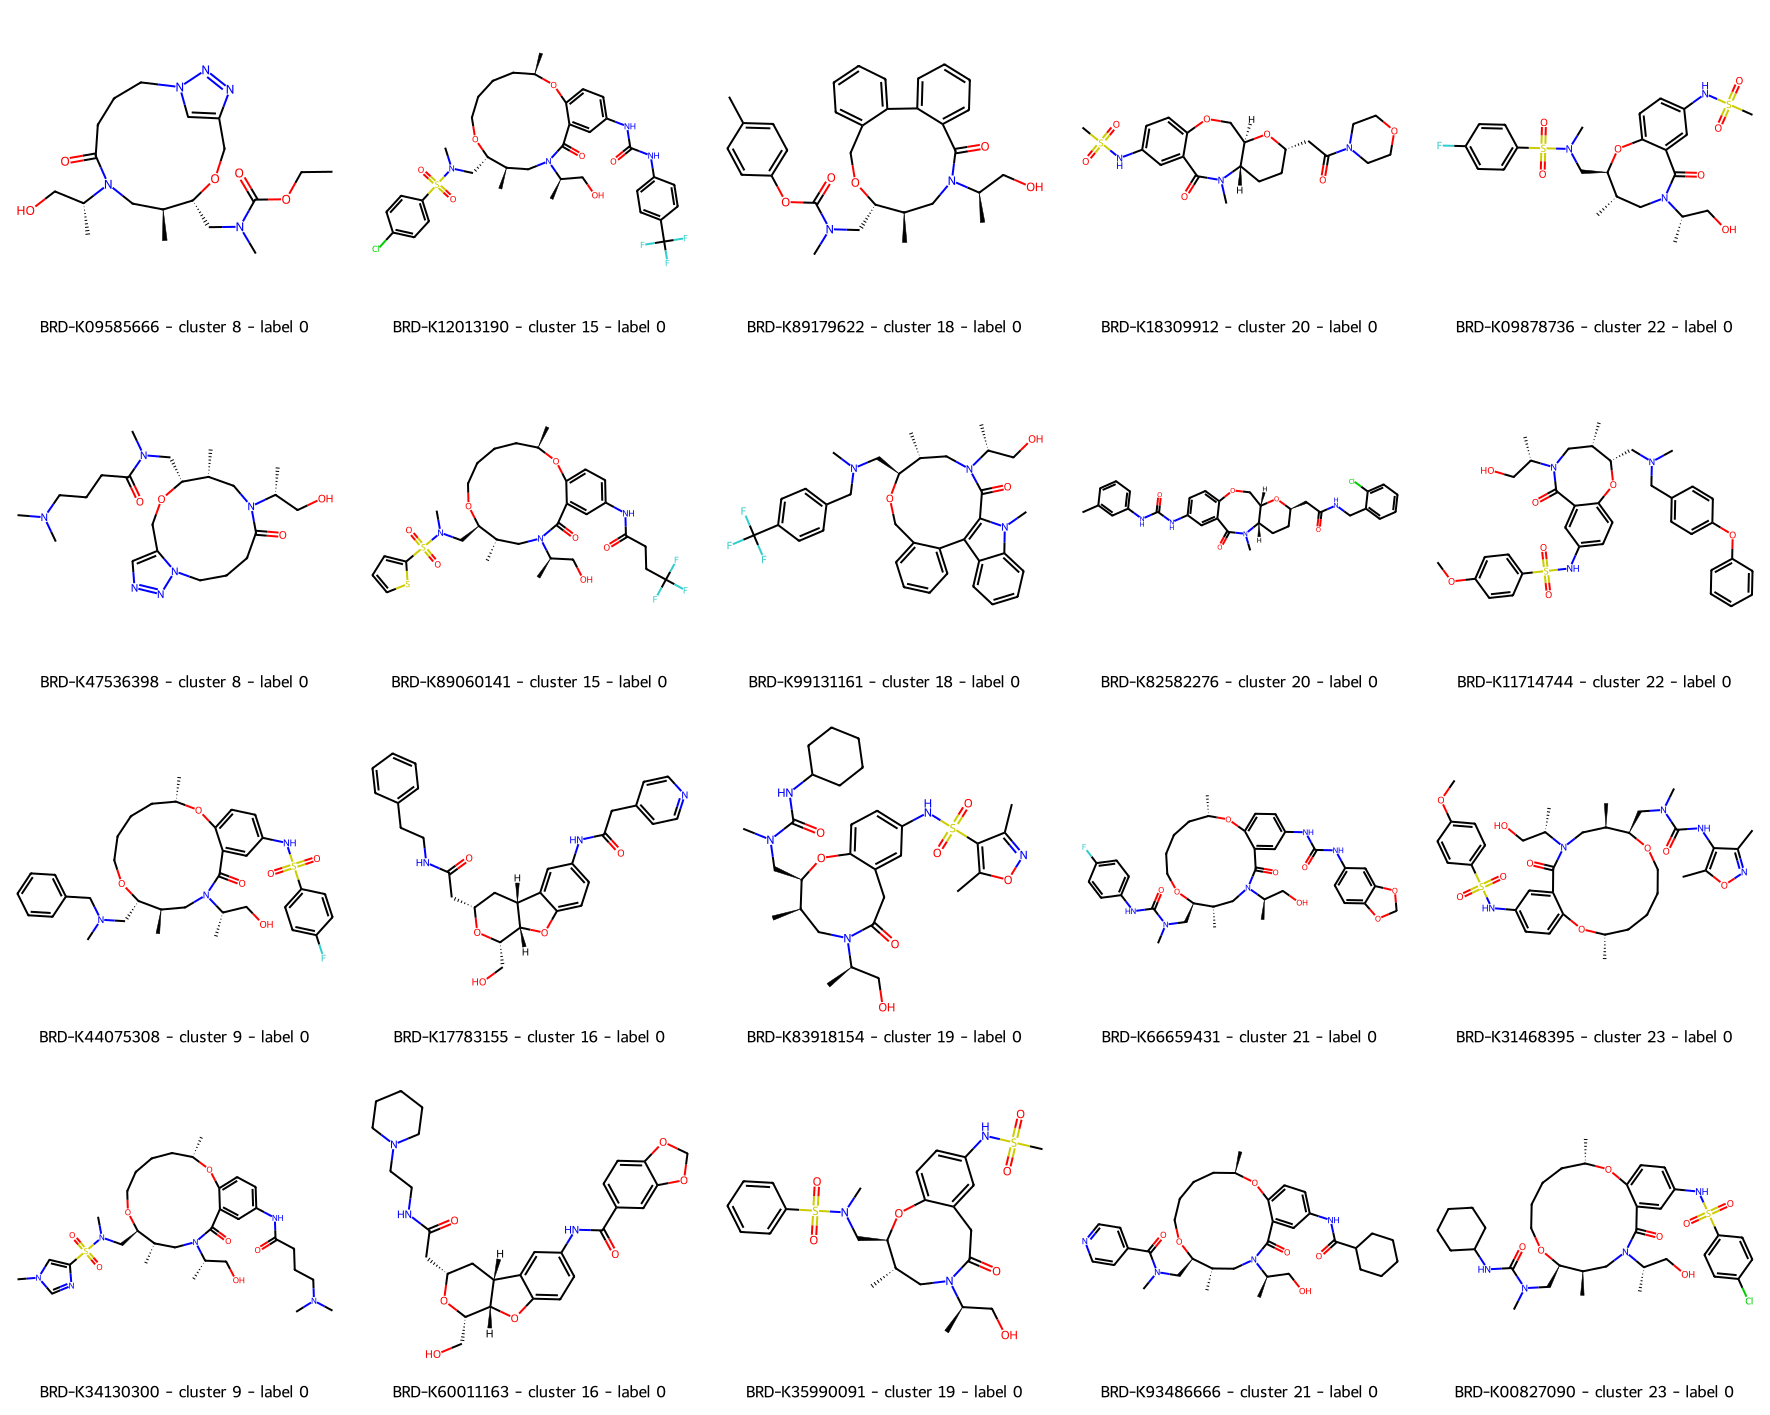

In [ ]:
imgs = []
for sm in sampleDF.itertuples():
    if sm.cluster_id not in summary[summary['sum']==0].index.values:
        continue
    # print(sm)
    # break
    d2d = Draw.MolDraw2DCairo(350,350)
    molecule = Chem.MolFromSmiles(sm.Smiles)
    imgs.append(show_mol(d2d,molecule,legend=f'{sm.CID} - cluster {sm.cluster_id} - label {sm.final_activity_label}'))

# imgs.append(show_mol(d2d,doravirine,legend='default palette'))
show_images(imgs, nrows=4)